# Dragonfly registration
While other tasks used standard emlddmm, this setup has a different geometry which requires a more involved setup.

Brain is cut into adjacent slabs.  Each slab deforms and shrinks/shifts/translates.  

We will use a version of projection LDDMM for this.




In version 00, we just do one forward pass, and one reconstruction of the slices

nothing nonlinear.  Everything looks nice so far and we have a reasonable initialization.

note that I may need a smaller voxel size, so we can really see the end of the slices


in v01 I will start optimizing

Next I will add nonlinaer

Some notes.
I think I will need to pad J so that there is some contrast at the ends

In version 2 I add a fixed translation to each slice, just like a fixed trapezoid sampling

in version 4 I add deformation to each slab, less smooth

In [1]:
# note this version for tme08

## Import Necessary Libraries

In [2]:
import PIL
PIL.__file__

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib widget

import time
import torch
from glob import glob

import os
from os.path import join,split,splitext
from os import makedirs

import sys
sys.path.append('..')
# sys.path.append('/ifshome/abenneck')
sys.path.append('/home/abenneck')
import importlib as imp
import donglab_workflows as dw
imp.reload(dw)

# for now add emlddmm library for registration
from emlddmm import emlddmm
imp.reload(emlddmm)

<module 'emlddmm.emlddmm' from '/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py'>

## Define Atlas + Load Atlas Images

Lists of all potential inputs for 'brain':
- [TME08-1, TME10-1, TME10-3, TME12-1, TME20-1]
- [Hpca5-2, Sp9-3-2, Trank1-2-3, Zswim4-1]
- [MQC06-2, MQC09-3, MQC18-3, MQC82-2]
- [hTME15-1, hTME15-2, hTME18-1, hTME19-2]
- [12m_MQC06-2, 12m_MQC15-1, 12m_MQC18-3, 12m_MQC07-5, 12m_MQC09-3, 12m_MQC6-4]

List of all potential inputs for 'orientation':
- 'L' for KO-Het_MORF brains
- 'R' for Q140_MORF brains
- 'W' for whole brains (TME)

In [3]:
# brain = 'TME07-1'
# brain = 'TME08-1'
# brain = 'TME09-1'
# brain = 'TME10-1'
# brain = 'TME10-3'
# brain = 'TME12-1'
# brain = 'TME20-1'
# brain = 'Hpca5-2'
# brain = 'Sp9-3-2'
# brain = 'Trank1-2-3'
# brain = 'Zswim4-1'
# brain = 'MQC06-2'
# brain = 'MQC09-3'
# brain = 'MQC18-3'
# brain = 'MQC82-2'
# brain = 'hTME15-1'
# brain = 'hTME15-2'
# brain = 'hTME18-1'
# brain = 'hTME19-2'
# brain = '12m_MQC06-2'
# brain = '12m_MQC15-1'
# brain = '12m_MQC18-3'
# brain = '12m_MQC07-5'
brain = '12m_MQC09-3'
# brain = '12m_MQC6-4'

# Change to 'L' or 'R' depending on orientation of hemisphere-only images and 'W' if whole brain
orientation = 'W'

if brain in ['TME08-1', 'TME10-1', 'TME10-3', 'TME12-1', 'TME20-1', 'TME07-1', 'TME09-1']:
    brain_path = brain
elif brain in ['MQC06-2', 'MQC09-3', 'MQC18-3', 'MQC82-2']: # The original HD brains
    brain_path = f'Q140_MORF/{brain}'
    orientation = 'R' 
elif '12m' in brain: # The new HD brains
    orientation = 'L'
    if '06-2' in brain or '15-1' in brain or '18-3' in brain:
        brain_path = f'Q140_MORF/Shasha_Q140/Camk-MORF3_{brain}'
    elif '09-3' in brain:
        brain_path = f'Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_{brain}'
    elif '07-5' in brain:
        brain_path = f'Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_{brain}'
        orientation = 'R'
    elif '6-4' in brain:
        brain_path = f'Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC6-4 (prev 6-3)'
        orientation = 'L'
    else:
        raise Exception('Invalid brain')
elif 'hTME' in brain:
    orientation = 'R'
    if 'hTME15-1' in brain or 'hTME19-2' in brain:
        brain_path = f'Q140_MORF_D1/Camk-MORF3-D1Tom_12m_{brain}'
    elif 'hTME15-2' in brain or 'hTME18-1' in brain:
        brain_path = f'Q140_MORF_D1/Camk-MORF3-D1Tom-Q140_12m_{brain}'
    else:
        raise Exception('Invalid brain')
else: # KO-Het_MORF
    orientation = 'L' 
    if 'Hpca' in brain:
        brain_path = f'KO-Het_MORF/HpcaKO-Camk-MORF3-D1tom_Hpca5-2'
    elif 'Sp9' in brain:
        brain_path = f'KO-Het_MORF/Sp9Het-Camk-MORF3-D1tom_Sp9-3-2'
    elif 'Trank' in brain:
        brain_path = f'KO-Het_MORF/Trank1KO-Camk-MORF3-D1tom_Trank1-2-3'
    elif 'Zswim' in brain:
        brain_path = f'KO-Het_MORF/Zswim6Het-Camk-MORF3-D1tom_Zswim4-1'
    else:
        raise Exception('Invalid brain')

output_prefix = f'/home/abenneck/dragonfly_work/{brain}'

In [4]:
# load atlas images
atlas_names = [
    '/nafs/dtward/allen_vtk/allen_vtk/ara_nissl_50.vtk',
    '/nafs/dtward/allen_vtk/allen_vtk/average_template_50.vtk',
]

seg_name = '/nafs/dtward/allen_vtk/allen_vtk/annotation_50.vtk'

### Figure 1

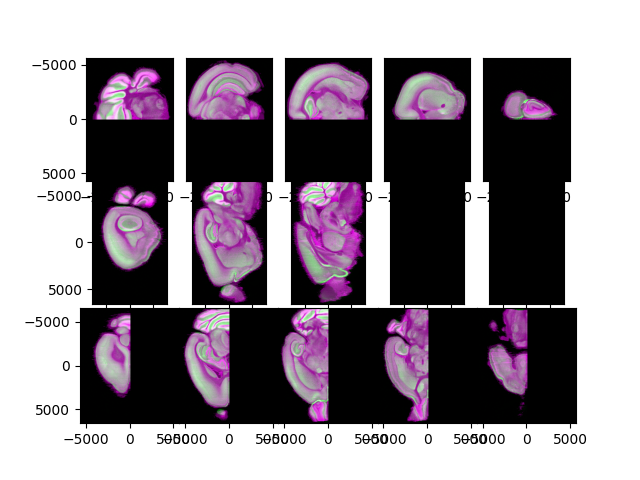

In [5]:
I = []
for atlas_name in atlas_names:
    xI,I_,title,names = emlddmm.read_data(atlas_name)
    I_ = I_.astype(np.float32)
    I_ /= np.mean(np.abs(I_))

    # Will zero-out atlas image for the hemisphere we are NOT aligning
    if orientation == 'R': # For images only containing a RIGHT  hemisphere
        I_[:,:,:int(np.shape(I_)[2]/2),:] = np.zeros([np.shape(I_)[0],np.shape(I_)[1],int(np.shape(I_)[2]/2),np.shape(I_)[3]])
    elif orientation == 'L': # For images only containing a LEFT hemisphere (+1 brings back fig[1,2])
        I_[:,:,int(np.shape(I_)[2]/2 + 1):,:] = np.zeros([np.shape(I_)[0],np.shape(I_)[1],int(np.shape(I_)[2]/2 - 1),np.shape(I_)[3]])
    else:
        print(f'{brain} contains whole-brain images, not hemispheres')
        
    I.append(I_)
    
I = np.concatenate(I)   
I[0] = I[0]**0.25
I[0] /= np.mean(np.abs(I_[0]))
dI = np.array([x[1] - x[0] for x in xI])
XI = np.stack(np.meshgrid(*xI,indexing='ij'),-1)

# {Plot figure
fig,ax = emlddmm.draw(I,xI,vmin=0)
fig.canvas.draw()

# Shows 2 images as a series of coronal, sagittal, and axial (top => down)
# - Magenta is 1st image and green is a serial 2-photon image

Using emlddmm.orientation_to_orientation('ARI','IRA')
- First argument will be constant ('ARI'), represents orientations of Atlas
- I will need to change second argument until I find proper alignment

Create an acronym of some order: containing 3 letters
- Ex: 'ALS'

First row: A <=> P
Second row: R <=> L
Third row: I <=> S

Order of acronym depends on order of rows 

For new brains, the third row is either A or P
- The first and second rows could be either R/L or I/S

## Choose Directory for Data to be Registered (TMEXX-Y)

In [6]:
if brain in ['12m_MQC18-3','12m_MQC15-1','12m_MQC09-3']:
    default_channel = 1
else:
    default_channel = 0

if 'TME07-1' in brain:
    target_dir = '/nafs/dtward/dong/dragonfly_03_2022'
else:
    target_dir = f'/panfs/dong/3D_registration/Yang_MORF_DragonFly/{brain_path}_downsampled/10x/ch_{default_channel}_pipeline_building'

if brain in ['MQC06-2', 'MQC09-3', 'MQC82-3', '12m_MQC15-1', '12m_MQC09-3'] or 'hTME' in brain:
    target_pattern = f'*10X*ch_{default_channel}_*.npz'
elif 'TME07-1' in brain:
    target_pattern = f'*10x*_channel_{default_channel}*.npz'
elif brain in ['12m_MQC06-2', '12m_MQC18-3']:
    target_pattern = f'*10x*ch_{default_channel}_*.npz'
    target_pattern_1 = f'*10X*ch_{default_channel}_*.npz'
else:
    target_pattern = f'*10x*ch_{default_channel}_*.npz'

In [7]:
# target_files = glob(join(target_dir,target_pattern))
# target_files.sort()
# target_files

In [8]:
target_files = []
for rootdir,directories,files in os.walk(target_dir):
    matched = glob(join(rootdir,target_pattern))
    if matched:
        target_files.extend(matched)
    # Some .npz files include '10x' and some include '10X'
    if brain in ['12m_MQC06-2', '12m_MQC18-3']:
        matched = glob(join(rootdir,target_pattern_1))
        if matched:
            target_files.extend(matched)
target_files.sort()
print(target_files)

['/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC-2(MQC9-3)10X S3_2020-11-15_11.56.04_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz', '/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC-2(MQC9-3)10X S6_2020-11-15_15.36.19_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz', '/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC-2(MQC9-3)10X S7_2020-11-15_16.11.54_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz', '/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC9-3 S1 10X_2020-12-21_10.20.04_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz', '/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsa

In [9]:
target_files

['/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC-2(MQC9-3)10X S3_2020-11-15_11.56.04_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC-2(MQC9-3)10X S6_2020-11-15_15.36.19_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC-2(MQC9-3)10X S7_2020-11-15_16.11.54_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC9-3 S1 10X_2020-12-21_10.20.04_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_do

In [10]:
# When sorted alphabetically, the file names of some brains were not in proper slab order, so I put the files in order manually here 
temp_target_files = []
if brain == '12m_MQC15-1':
    temp_target_files.append(target_files[2])
    temp_target_files.append(target_files[3])
    temp_target_files.append(target_files[4])
    temp_target_files.append(target_files[0])
    temp_target_files.append(target_files[1])
    target_files = temp_target_files
elif brain == '12m_MQC18-3':
    temp_target_files.append(target_files[0])
    temp_target_files.append(target_files[5])
    temp_target_files.append(target_files[6])
    temp_target_files.append(target_files[1])
    temp_target_files.append(target_files[2])
    temp_target_files.append(target_files[3])
    temp_target_files.append(target_files[4])
    target_files = temp_target_files    
elif brain == '12m_MQC09-3':
    temp_target_files.append(target_files[3])
    temp_target_files.append(target_files[4])
    temp_target_files.append(target_files[0])
    temp_target_files.append(target_files[5])
    temp_target_files.append(target_files[6])
    temp_target_files.append(target_files[1])
    temp_target_files.append(target_files[2])
    target_files = temp_target_files 
elif brain == '12m_MQC6-4':
    temp_target_files.append(target_files[1])
    temp_target_files.append(target_files[2])
    temp_target_files.append(target_files[4])
    temp_target_files.append(target_files[3])
    temp_target_files.append(target_files[5])
    temp_target_files.append(target_files[0])
    target_files = temp_target_files
elif brain == "Trank1-2-3":
    temp_target_files.append(target_files[0])
    temp_target_files.append(target_files[1])
    temp_target_files.append(target_files[3])
    temp_target_files.append(target_files[2])
    temp_target_files.append(target_files[4])
    temp_target_files.append(target_files[5])
    temp_target_files.append(target_files[6])
    temp_target_files.append(target_files[7])
    target_files = temp_target_files
target_files

['/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC9-3 S1 10X_2020-12-21_10.20.04_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC9-3 S2 10X_2020-12-21_10.39.43_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC-2(MQC9-3)10X S3_2020-11-15_11.56.04_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC9-3 S410X_2020-12-24_13.30.22_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz',
 '/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x

### Plot a Maximum Intensity Projection of either slice 'idx' or slice '-1'

['I', 'I2', 'xI', 'w']


Text(0.5, 1.0, 'MQC-2(MQC9-3)10X S7_2020-11-15_16.11.54_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz')

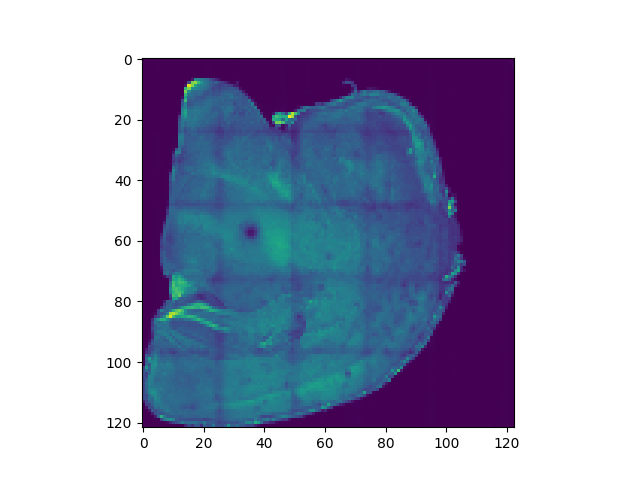

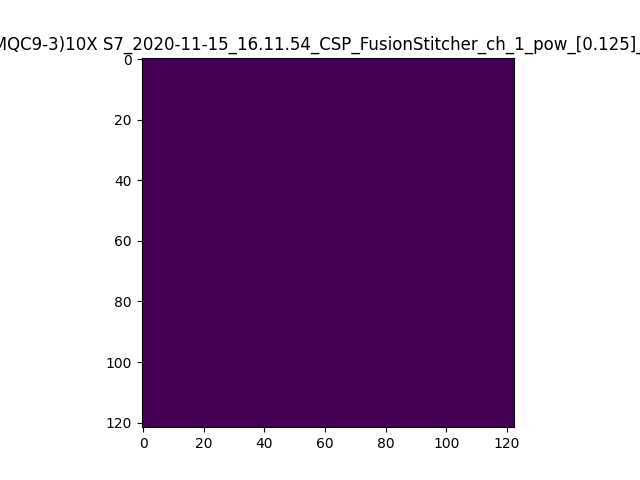

In [11]:
###### test
idx = 6
data = np.load(target_files[idx],allow_pickle=True)
# data = np.load(target_files[-1],allow_pickle=True)
print([k for k in data])

if 'TME07-1' in brain:
    W_ = data['W']
else:
    W_ = data['w']

I_ = data['I']
vmin = np.quantile(I_[W_>0.99],0.1)
vmax = np.quantile(I_[W_>0.99],0.9)
I_.shape
fig,ax = plt.subplots()
ax.imshow(np.max(I_,0),vmin=vmin)
fig,ax = plt.subplots()
ax.imshow(np.max(W_,0))
ax.set_title(os.path.split(target_files[idx])[-1])

# 1st panel is a maximum intensity projection (Common way to view microscopy today, especially w fluorescence labeling)
# No info acquired in purple corners

# Load the Data

In [12]:
# load the data
Js = []
xJs = []
Ws = []
dJs = []
DJs = []
for fname in target_files:
    print(fname)
    data = np.load(fname,allow_pickle=True)
    Js.append(data['I'][None])    
    
    # We decided to ignore voxel positions and use zero-mean convention b/c it is more numerically stable
    # data['xI'] is a list of 3 1d arrays with z,y,x locations 
    # xJs.append(data['xI'])
    if 'TME' in brain:
        xJs.append([d-np.mean(d) for d in data['xI']])
    else:
        xJs.append([data['xI'][0] - np.mean(data['xI'][0]), data['xI'][1] - np.mean(data['xI'][1]), data['xI'][2]])
        

    if 'W' in data or 'w' in data:
        if 'W' in data:
            key = 'W'
        else:
            key = 'w'
        W_ = data[key]
        if W_.ndim == 4:
            W_ = W_[0]
        Ws.append(W_)
    else:
        #Ws.append(np.zeros_like(Js[0]))
        # I think this should be ones
        Ws.append(np.ones_like(Js[0]))
    
    
    # we need to normalize to [0,1]
    mymin = np.quantile(Js[-1][Ws[-1][None]>0.99],0.05)
    mymax = np.quantile(Js[-1][Ws[-1][None]>0.99],0.99)
    #print(mymin,mymax)
    Js[-1] = (Js[-1] - mymin)/(mymax - mymin)
    
    # I'd like to squash the bright signal
    signJ = np.sign(Js[-1])
    Js[-1] = signJ*abs(Js[-1])**0.25

    
    # we need to normalize to [0,1] again!
    mymin = np.quantile(Js[-1][Ws[-1][None]>0.99],0.05)
    mymax = np.quantile(Js[-1][Ws[-1][None]>0.99],0.99)
    #print(mymin,mymax)
    Js[-1] = (Js[-1] - mymin)/(mymax - mymin)
    # after scaling I'm going to zero out the low signals (new feb 2 2023)
    Js[-1][Js[-1]<0.0] = 0.0
    # also I think the weights are not strong enough
    Ws[-1][Ws[-1]<0.999] = 0.0
    
    dJs.append([x[1]-x[0] for x in xJs[-1]])
    DJs.append(np.prod(dJs[-1]) )

# Js[i].shape[1] == xJs[i][0].shape[0]

    # note, sometimes xJs don't match Js
    for s in [-1,-2,-3]:
        if len(xJs[-1][s]) != Js[-1].shape[s]:
            print('mismatch')
            print(f'x size {len(xJs[-1][s])} doesn\'t match J size {Js[-1].shape[s]}')
            n = Js[-1].shape[s] - len(xJs[-1][s]) 
            d = xJs[-1][s][1] - xJs[-1][s][0]
            xJs[-1][s] = np.concatenate((xJs[-1][s],[xJs[-1][s][-1]+d ]))
    
    # # note, sometimes xJs don't match Js
    # s = -1
    # if len(xJs[-1][s]) != Js[-1].shape[s]:
    #     print('mismatch')
    #     print(f'x size {len(xJs[-1][s])} doesn\'t match J size {Js[-1].shape[s]}')
    #     n = Js[-1].shape[s] - len(xJs[-1][s]) 
    #     d = xJs[-1][s][1] - xJs[-1][s][0]
    #     xJs[-1][s] = np.concatenate((xJs[-1][s],[xJs[-1][s][-1]+d ]))

    
    

/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC9-3 S1 10X_2020-12-21_10.20.04_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz
/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC9-3 S2 10X_2020-12-21_10.39.43_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz
/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC-2(MQC9-3)10X S3_2020-11-15_11.56.04_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz
/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_building/MQC9-3 S410X_2020-12-24_13.30.22_CSP_FusionStitcher_ch_1_pow_[0.125]_down.npz
/panfs/dong/3D_registration/Yang_MORF_DragonFly/Q140_MORF/Shasha_Q140/Camk-MORF3-Q140_12m_MQC09-3_downsampled/10x/ch_1_pipeline_bui

### Figure 3

(array([4.502e+03, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        6.000e+00, 8.000e+00, 1.000e+01, 2.600e+01, 3.900e+01, 5.000e+01,
        5.800e+01, 1.010e+02, 1.500e+02, 2.020e+02, 2.820e+02, 4.330e+02,
        6.930e+02, 1.027e+03, 1.468e+03, 1.984e+03, 2.504e+03, 3.110e+03,
        3.671e+03, 3.534e+03, 2.790e+03, 2.219e+03, 1.739e+03, 1.188e+03,
        6.950e+02, 4.050e+02, 2.680e+02, 2.270e+02, 1.960e+02, 2.080e+02,
        1.960e+02, 3.050e+02, 3.500e+02, 3.510e+02, 3.190e+02, 3.490e+02,
        3.570e+02, 3.520e+02, 3.420e+02, 3.060e+02, 3.140e+02, 4.020e+02,
        3.640e+02, 3.540e+02, 3.310e+02, 3.960e+02, 3.910e+02, 3.840e+02,
        4.640e+02, 4.780e+02, 4.510e+02, 5.240e+02, 5.420e+02, 6.330e+02,
        6.550e+02, 8.130e+02, 9.170e+02, 1.029e+03, 1.198e+03, 1.312e+03,
        1.542e+03, 1.880e+03, 2.162e+03, 2.411e+03, 2.699e+03, 2.923e+03,
        3.116e+03, 3.294e+03, 3.364e+03, 3.314e+03, 2.970e+03, 2.655e+03,
        2.198e+03, 1.929e+03, 1.617e+0

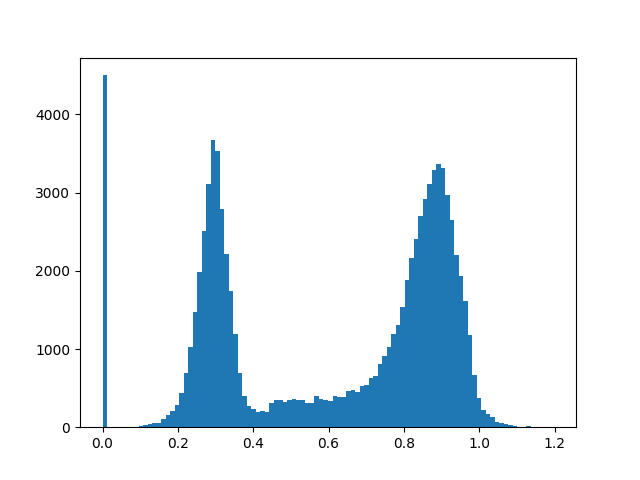

In [13]:
f,ax = plt.subplots()
ax.hist(Js[-1][Ws[-1][None]>0.99].ravel(),100)

# Histogram of intensity values of the last slice [-1], using logical indexing to only consider portion of image where 
# data was acquired (yellow in 2nd panel of above image (Ws))

In [14]:
# Prints out size and shape
# (***) Check that Js, Ws, and Xs are all the same size
# --- Xs tells us the location of every pixel
# (***) Check which of 2 possible ways that Xs are defined
# - (1) Origin placed in center of image (Mean of Xs is ~0)
# - (2) Origin placed wherever the microscope declared it to be
for i in range(len(Js)):
    print(f'idx {i}:')
    if Js[i].shape[0] != 1:
        print("Incorrect dimension Js[i].shape[0]")
        
    if Js[i].shape[1] == Ws[i].shape[0] and Js[i].shape[1] == xJs[i][0].shape[0]:
        print(f"Correct dimension 1: {Js[i].shape[1]}")
    else:
        print(f'(***) Incorrect dimension 1: {Js[i].shape[1]} ?= {Ws[i].shape[0]} and {Js[i].shape[1]} ?= {xJs[i][0].shape[0]}')
        
    if Js[i].shape[2] == Ws[i].shape[1] and Js[i].shape[2] == xJs[i][1].shape[0]:
        print(f"Correct dimension 2: {Js[i].shape[2]}")    
    else:
        print(f'(***) Incorrect dimension 2: {Js[i].shape[2]} ?= {Ws[i].shape[1]} and {Js[i].shape[2]} ?= {xJs[i][1].shape[0]}')
        
    if Js[i].shape[3] == Ws[i].shape[2] and Js[i].shape[3] == xJs[i][2].shape[0]:
        print(f"Correct dimension 3: {Js[i].shape[3]}")
    else:
        print(f'(***) Incorrect dimension 1: {Js[i].shape[3]} ?= {Ws[i].shape[2]} and {Js[i].shape[3]} ?= {xJs[i][2].shape[0]}')

    print()

idx 0:
Correct dimension 1: 5
Correct dimension 2: 73
Correct dimension 3: 49

idx 1:
Correct dimension 1: 4
Correct dimension 2: 74
Correct dimension 3: 74

idx 2:
Correct dimension 1: 6
Correct dimension 2: 122
Correct dimension 3: 98

idx 3:
Correct dimension 1: 5
Correct dimension 2: 82
Correct dimension 3: 62

idx 4:
Correct dimension 1: 4
Correct dimension 2: 82
Correct dimension 3: 62

idx 5:
Correct dimension 1: 6
Correct dimension 2: 122
Correct dimension 3: 98

idx 6:
Correct dimension 1: 7
Correct dimension 2: 122
Correct dimension 3: 123



## Data Augmentation (Padding)

In [15]:
# I want to pad everything, so that we could see the edges of the slab (for alignment purposes)
for i in range(len(Js)):
    Ji = Js[i]
    Wi = Ws[i]
    xJi = xJs[i]
    dJi = dJs[i]
    
    # find the 1% quantile
    #val = np.quantile(Ji[Wi[None]>=0.99],0.05)
    val = np.quantile(Ji[Wi[None]>=0.99],0.1)
    #val = 0.0
    npad = 2
    Ji = np.pad(Ji,((0,0),(npad,npad),(0,0),(0,0)), constant_values=val)
    Wi = np.pad(Wi,((npad,npad),(0,0),(0,0)), constant_values=1.0)
    for j in range(npad):
        # Grows the Xs, so that we know the location of the padded pixesl too
        xJi[0] = np.concatenate((xJi[0][0][None]-dJi[0], xJi[0], xJi[0][-1][None]+dJi[0]))
    
    Js[i] = Ji
    Ws[i] = Wi
    xJs[i] = xJi
    

In [16]:
# Checks that Js, Ws, and Xs are still same size
for i in range(len(Js)):
    print(f'idx {i}:')
    if Js[i].shape[0] != 1:
        print("Incorrect dimension Js[i].shape[0]")
        
    if Js[i].shape[1] == Ws[i].shape[0] and Js[i].shape[1] == xJs[i][0].shape[0]:
        print(f"Correct dimension 1: {Js[i].shape[1]}")
    else:
        print(f'(***) Incorrect dimension 1: {Js[i].shape[1]} ?= {Ws[i].shape[0]} and {Js[i].shape[1]} ?= {xJs[i][0].shape[0]}')
        
    if Js[i].shape[2] == Ws[i].shape[1] and Js[i].shape[2] == xJs[i][1].shape[0]:
        print(f"Correct dimension 2: {Js[i].shape[2]}")    
    else:
        print(f'(***) Incorrect dimension 2: {Js[i].shape[2]} ?= {Ws[i].shape[1]} and {Js[i].shape[2]} ?= {xJs[i][1].shape[0]}')
        
    if Js[i].shape[3] == Ws[i].shape[2] and Js[i].shape[3] == xJs[i][2].shape[0]:
        print(f"Correct dimension 3: {Js[i].shape[3]}")
    else:
        print(f'(***) Incorrect dimension 1: {Js[i].shape[3]} ?= {Ws[i].shape[2]} and {Js[i].shape[3]} ?= {xJs[i][2].shape[0]}')

    print()

idx 0:
Correct dimension 1: 9
Correct dimension 2: 73
Correct dimension 3: 49

idx 1:
Correct dimension 1: 8
Correct dimension 2: 74
Correct dimension 3: 74

idx 2:
Correct dimension 1: 10
Correct dimension 2: 122
Correct dimension 3: 98

idx 3:
Correct dimension 1: 9
Correct dimension 2: 82
Correct dimension 3: 62

idx 4:
Correct dimension 1: 8
Correct dimension 2: 82
Correct dimension 3: 62

idx 5:
Correct dimension 1: 10
Correct dimension 2: 122
Correct dimension 3: 98

idx 6:
Correct dimension 1: 11
Correct dimension 2: 122
Correct dimension 3: 123



In [17]:
# raise Exception('Check Sizes')

### (****) Figures 4 & 5

{}
{}


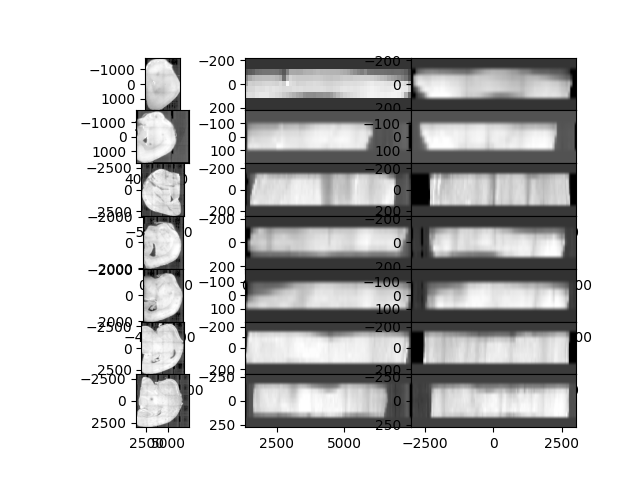

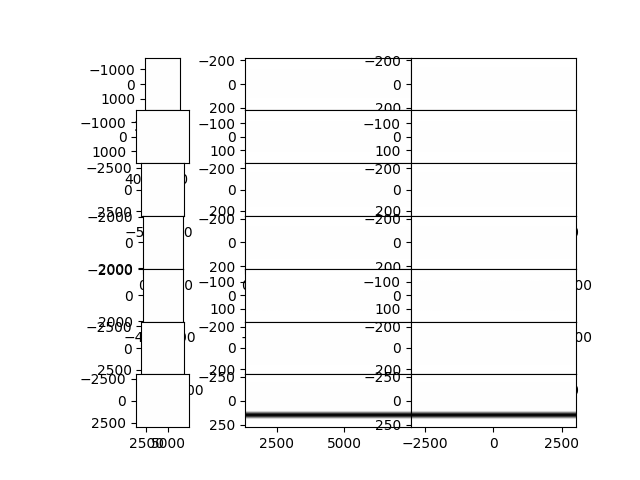

In [18]:
def clip(I):
    I = np.copy(I)
    I[I<0] = 0
    I[I>1] = 1
    return I
def draw_stack(Js,xJs,fig=None,**kwargs):
    '''
    stack is on the first axis
    note there is an issue with sharex and removing the axis labels
    also an issue cause the images are different number of slices
    Not using now
    TODO: make sure this will work with numpy or torch
    avoid copying too much

    '''
    #print(kwargs)
    if 'vmin' in kwargs:
        vmin = kwargs.pop('vmin')
    else:
        vmin = np.min([np.min(np.array(J)) for J in Js])
    if 'vmax' in kwargs:
        vmax = kwargs.pop('vmax')
    else:
        vmax = np.min([np.max(np.array(J)) for J in Js])    
    print(kwargs)
    
    
    n = len(Js)
    if fig is None:
        figsize = (5,10)
        figsize = None
        fig = plt.figure(figsize=figsize)
    else:
        fig.clf()
    
    
    for i in range(n):
        if i == 0:
            ax0 = fig.add_subplot(n,3,3*i+1)
            ax = ax0
        else:
            ax0 = None
            ax = fig.add_subplot(n,3,3*i+1,sharex=ax0,sharey=ax0)
        # note I make a copy here
        toshow = np.array(Js[i][:,Js[i].shape[1]//2]).transpose(1,2,0)
        if toshow.shape[-1] == 1:
            toshow = np.concatenate((toshow,toshow,toshow),-1)
        elif toshow.shape[-1] == 2:
            toshow = np.stack((toshow[...,0],toshow[...,1],toshow[...,0]),-1)
        else:
            toshow = toshow[...,:3]
        toshow -= vmin
        toshow /= vmax-vmin
        xJ = xJs[i]
        dJ = [x[1]-x[0] for x in xJ]
        extent = (xJ[-1][0]-dJ[-1]*0.5,xJ[-1][-1]+dJ[-1]*0.5,
                 xJ[-2][-1]+dJ[-2]*0.5,xJ[-2][0]-dJ[-2]*0.5)
        ax.imshow(clip(toshow),extent=extent,**kwargs)
        #if i < n-1:
        #    ax.set_xticks([])
                
        if i == 0:
            ax1 = fig.add_subplot(n,3,3*i+2)
            ax = ax1
        else:
            ax1 = None
            ax = fig.add_subplot(n,3,3*i+2,sharex=ax1,sharey=ax1)
        toshow = np.array(Js[i][:,:,Js[i].shape[2]//2]).transpose(1,2,0)
        if toshow.shape[-1] == 1:
            toshow = np.concatenate((toshow,toshow,toshow),-1)
        elif toshow.shape[-1] == 2:
            toshow = np.stack((toshow[...,0],toshow[...,1],toshow[...,0]),-1)
        else:
            toshow = toshow[...,:3]
        toshow -= vmin
        toshow /= vmax-vmin
        
        
        extent = (xJ[-1][0]-dJ[-1]*0.5,xJ[-1][-1]+dJ[-1]*0.5,
                 xJ[-3][-1]+dJ[-3]*0.5,xJ[-3][0]-dJ[-3]*0.5)        
        ax.imshow(clip(toshow),extent=extent,**kwargs)
        ax.set_aspect('auto')
        #if i < n-1:
        #    ax.set_xticks([])
        
        
        if i == 0:
            ax2 = fig.add_subplot(n,3,3*i+3)
            ax = ax2
        else:
            ax2 = None
            ax = fig.add_subplot(n,3,3*i+3,sharex=ax2,sharey=ax2)
        toshow = np.array(Js[i][:,:,:,Js[i].shape[3]//2]).transpose(1,2,0)
        if toshow.shape[-1] == 1:
            toshow = np.concatenate((toshow,toshow,toshow),-1)
        elif toshow.shape[-1] == 2:
            toshow = np.stack((toshow[...,0],toshow[...,1],toshow[...,0]),-1)            
        else:
            toshow = toshow[...,:3]
        toshow -= vmin
        toshow /= vmax-vmin
        extent = (xJ[-2][0]-dJ[-2]*0.5,xJ[-2][-1]+dJ[-2]*0.5,
                 xJ[-3][-1]+dJ[-3]*0.5,xJ[-3][0]-dJ[-3]*0.5)
        ax.imshow(clip(toshow),extent=extent,**kwargs)
        ax.set_aspect('auto')
        #if i < n-1:
        #    ax.set_xticks([])
        plt.subplots_adjust(wspace=0,hspace=0)
        
    return fig,None # later I will return ax
        

vminJ = 0.99
vmaxJ = 1.01

vminJ = 0.0
vmaxJ = 1.0

fig,ax = draw_stack(Js,xJs,vmin=vminJ,vmax=vmaxJ)
fig.canvas.draw()
fig,ax = draw_stack([w[None] for w in Ws],xJs,vmin=0,vmax=1)
fig.canvas.draw()
    
# Looking at the axis label, we see that the origin is the center of the images
# -- Slices for each slab

# 2nd panel - Anywhere with black is missing info (Similar to the yellow/purple from before)

In [19]:
# now we have to firm up the model
# as usual, I will start with just linear
# then I'll add the projection step


In [20]:
# lets convert to torch

1. Change the shape of the atlas in 3D to match our dataset
2. Then we match the pose via linear transformations
3. Cut out 50 um slabs from the atlas
4. Allow a per-slab change in shape (1m parameters to estimate)
5. Allow a per-slab change in pose (Orientation and scale, ~O(10) parameters to estimate)

In [21]:
Inp = np.copy(I)
xInp = [np.copy(x) for x in xI]
Jnp = [np.copy(Ji) for Ji in Js]
xJnp = [[np.copy(x) for x in xJ] for xJ in xJs]
Wnp = [np.copy(Wi) for Wi in Ws]

In [22]:
# device = 'cpu'
device = 'cuda:1'
dtype = torch.float64
I = torch.tensor(Inp,device=device,dtype=dtype)
xI = [torch.tensor(x,device=device,dtype=dtype) for x in xInp]
J = [torch.tensor(Ji,device=device,dtype=dtype) for Ji in Jnp]
W = [torch.tensor(Wi,device=device,dtype=dtype) for Wi in Wnp]
xJ = [[torch.tensor(x,device=device,dtype=dtype) for x in xJi] for xJi in xJnp]
XJ = [ torch.stack(torch.meshgrid(x[0],x[1],x[2],indexing='ij'),-1) for x in xJ]
# note I'm stacking at the end
# I think I may have to stack at the start
XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)

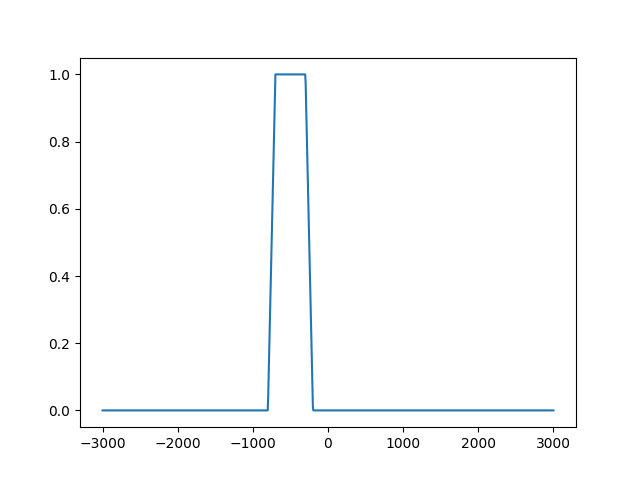

In [23]:
# lets build a trapezoid function
dslice = 500.0 # 500 micron slices
def trapezoid(x,i):
    # if it is in the middle
    d = torch.abs(x - (i - (len(J)-1)/2.0)*dslice)
    out = (d < dslice/2.0)*1.0 + (d >= dslice/2.0)*(d < dslice/2.0+dI[0])*(1.0 - (d-dslice/2.0)/dI[0])    
    return out
def trapezoid(x,i):
    # if it is in the middle
    d = torch.abs(x - (i - (len(J)-1)/2.0)*dslice)
    out = (d < dslice/2.0 - dI[0])*1.0 + (d >= dslice/2.0 - dI[0])*(d < dslice/2.0+dI[0])*(1.0 - (d-dslice/2.0)/dI[0])*0.5
    return out
# I want the edge to be at 0.5, and take one voxel to go up or down
t = torch.linspace(-3000,3000,1000)
f,ax = plt.subplots()
ax.plot(t,trapezoid(t,2))

(<Figure size 640x480 with 15 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

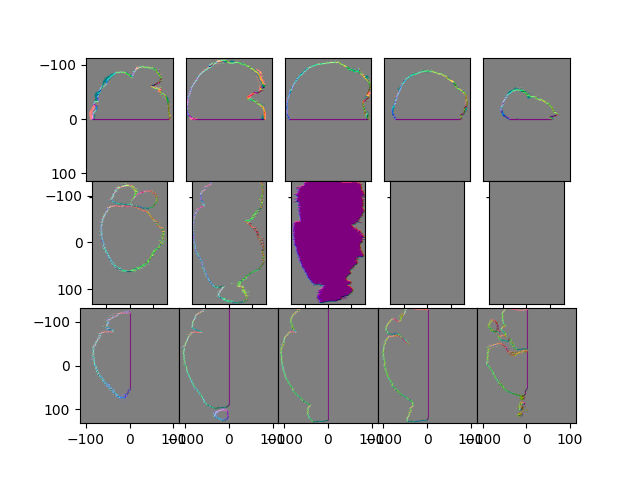

In [24]:
DI = torch.prod(torch.tensor(dI,device=device,dtype=dtype))

W_ = (I[0] > 0).to(dtype)
DW = torch.stack(torch.gradient(W_,spacing=dI.tolist(),dim=(0,1,2)),-1)
emlddmm.draw(DW.permute(-1,0,1,2))

# Attempt to estimate an inner product on the space parameters over which we are optimizing
# -- Must be estimated - 12x12 matrix which tells us how to compute
# -- Modified dot product which allows us to perform gradient descent in a better way
# -- Norm will be big if it changes the image a lot and small if it changes a little
# Color corresponds to the direction of the derivative (X-, Y-, and Z-)
# -- Measures how changing the affine matrix changes the 

In [25]:
# Builds the 12x12 matrix using the derivative of the image
gid = torch.zeros(12,12,device=device,dtype=dtype)

count0 = 0
for i0 in range(3):
    for j0 in range(4):
        E0 = ((torch.arange(4,device=device,dtype=dtype)==i0)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j0)[None,:]).to(dtype)
        if j0 == 3:
            tosum0 = DW[...,i0]
        else:
            tosum0 = DW[...,i0]*XI[...,j0]
            
        count1 = 0
        for i1 in range(3):
            for j1 in range(4):
                if count0 > count1:
                    count1 += 1
                    continue                                
                E1 = ((torch.arange(4,device=device,dtype=dtype)==i1)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j1)[None,:]).to(dtype)                
                if j1 == 3:
                    tosum1 = DW[...,i1]
                else:
                    tosum1 = DW[...,i1]*XI[...,j1]
                                                            
                gid[count0,count1] = torch.sum(tosum0*tosum1)*DI
                gid[count1,count0] = gid[count0,count1]                                
                
                count1 += 1
        count0 += 1

In [26]:
def small_to_big(a):
    '''
    Convert A to a big linear map that acts on a vectorized matrix
    We compute it through its action on basis vectors
    '''
    
    A = torch.zeros(12,12,dtype=a.dtype,device=a.device)
    device = a.device
    dtype = a.dtype
    count0 = 0
    for i0 in range(3):
        for j0 in range(4):
            E0 = ((torch.arange(4,device=device,dtype=dtype)==i0)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j0)[None,:]).to(dtype)
            
            A[:,count0] = (a@E0)[:3,:4].ravel()
            count0 += 1
    return A


In [27]:
def gA_from_gid(gid,A):
    # we need to convert A to a 12x12 map
    A_ = small_to_big(torch.linalg.inv(A))
    gA = A_.T@gid@A_
    return gA    

(<Figure size 640x480 with 15 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

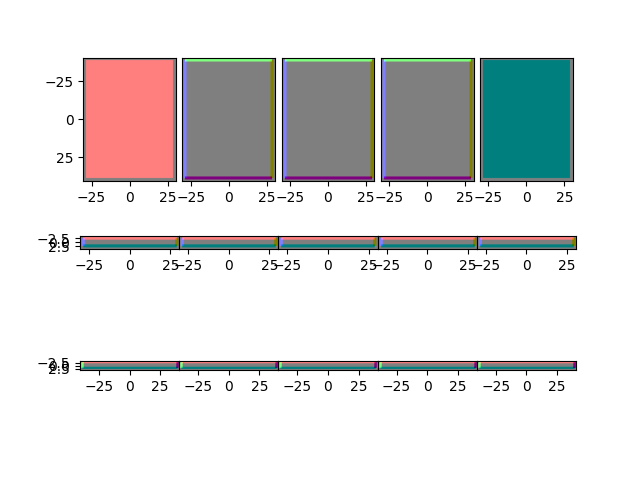

In [28]:
# How to use the inner product for the 2D affine

# now we need to do the same for gJ
# but these will change
# so instead we'll just do this
Jind = len(XJ)//2
W_ = torch.ones_like(XJ[Jind][...,0])
border = 2
W_[:border] = 0.0
W_[-border:] = 0.0
W_[:,:border] = 0.0
W_[:,-border:] = 0.0
W_[:,:,:border] = 0.0
W_[:,:,-border:] = 0.0


DW = torch.stack(torch.gradient(W_,spacing=dI.tolist(),dim=(0,1,2)),-1)
emlddmm.draw(DW.permute(-1,0,1,2))

In [29]:
gJid = torch.zeros(12,12,device=device,dtype=dtype)

count0 = 0
for i0 in range(3):
    for j0 in range(4):
        E0 = ((torch.arange(4,device=device,dtype=dtype)==i0)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j0)[None,:]).to(dtype)
        if j0 == 3:
            tosum0 = DW[...,i0]
        else:
            tosum0 = DW[...,i0]*XJ[Jind][...,j0]
            
        count1 = 0
        for i1 in range(3):
            for j1 in range(4):
                if count0 > count1:
                    count1 += 1
                    continue                                
                E1 = ((torch.arange(4,device=device,dtype=dtype)==i1)[:,None]*(torch.arange(4,device=device,dtype=dtype)==j1)[None,:]).to(dtype)                
                if j1 == 3:
                    tosum1 = DW[...,i1]
                else:
                    tosum1 = DW[...,i1]*XJ[Jind][...,j1]
                                                            
                gJid[count0,count1] = torch.sum(tosum0*tosum1)*DJs[Jind]
                gJid[count1,count0] = gJid[count0,count1]                                
                
                count1 += 1
        count0 += 1

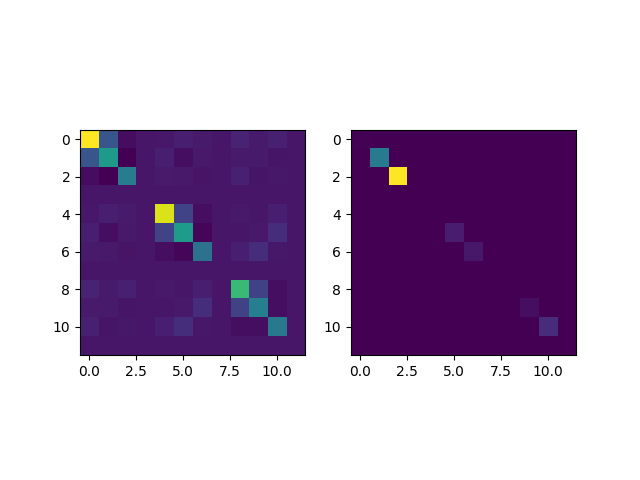

In [30]:
f,ax = plt.subplots(1,2)
ax[0].imshow(gid.cpu())
ax[1].imshow(gJid.cpu())

# If the matrix were the identity, it would be identical to a Euclidean inner product
# -- Accounts for differences in units

In [31]:
# set up kernels
dv = torch.tensor([1.0,1.0,1.0],device=device,dtype=dtype)*500.0
DV = torch.prod(dv)
dI = torch.tensor(dI,device=device,dtype=dtype)
v_expand_factor = 0.1
a = 500.0
p = 2.0
aprefactor = 0.25
nt = 5

print(f'a scale is {a}')
x0v = [x[0] - (x[-1]-x[0])*v_expand_factor for x in xI]
x1v = [x[-1] + (x[-1]-x[0])*v_expand_factor for x in xI]
xv = [torch.arange(x0,x1,d,device=device,dtype=dtype) for x0,x1,d in zip(x0v,x1v,dv)]
nv = torch.tensor([len(x) for x in xv],device=device,dtype=dtype)
XV = torch.stack(torch.meshgrid(xv),-1)

# build energy operator for velocity
fv = [torch.arange(n,device=device,dtype=dtype)/d/n for n,d in zip(nv,dv)]
FV = torch.stack(torch.meshgrid(fv))

LL = (1.0 - 2.0*a**2 * 
          ( (torch.cos(2.0*np.pi*FV[0]*dv[0]) - 1)/dv[0]**2  
        + (torch.cos(2.0*np.pi*FV[1]*dv[1]) - 1)/dv[1]**2  
        + (torch.cos(2.0*np.pi*FV[2]*dv[2]) - 1)/dv[2]**2   ) )**(p*2)
K = 1.0/LL

LLpre = (1.0 - 2.0*(aprefactor*torch.max(dI))**2 * 
         ( (torch.cos(2.0*np.pi*FV[0]*dv[0]) - 1)/dv[0]**2  
         + (torch.cos(2.0*np.pi*FV[1]*dv[1]) - 1)/dv[1]**2  
         + (torch.cos(2.0*np.pi*FV[2]*dv[2]) - 1)/dv[2]**2   ) )**(p*2)
Kpre = 1.0/LLpre
KK = K*Kpre

# Define the spatial scale, following a form commonly used in the literature

a scale is 500.0


/home/abenneck/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [32]:
# set up kernels for blocks
dvJ = torch.tensor([1.0,1.0,1.0],device=device,dtype=dtype)*100.0
DVJ = torch.prod(dvJ)
v_expand_factor = 0.1
aJ = 50.0
pJ = 2.0
aprefactorJ = 0.25
ntJ = 3

print(f'aJ scale is {aJ}')
LLJ = []
KJ = []
KJpre = []
XVJ = []
xvJ = []
for i in range(len(J)):
    x0vJ = [x[0] - (x[-1]-x[0])*v_expand_factor for x in xJs[i]]
    x1vJ = [x[-1] + (x[-1]-x[0])*v_expand_factor for x in xJs[i]]    
    xvJi = [torch.arange(x0,x1,d,device=device,dtype=dtype) for x0,x1,d in zip(x0vJ,x1vJ,dvJ)]
    nvJi = torch.tensor([len(x) for x in xvJi],device=device,dtype=dtype)
    XVJi = torch.stack(torch.meshgrid(xvJi),-1)

    
    
    # build energy operator for velocity
    fvJi = [torch.arange(n,device=device,dtype=dtype)/d/n for n,d in zip(nvJi,dvJ)]
    FVJi = torch.stack(torch.meshgrid(fvJi))

    LLJi = (1.0 - 2.0*aJ**2 * 
            ( (torch.cos(2.0*np.pi*FVJi[0]*dvJ[0]) - 1)/dvJ[0]**2  
            + (torch.cos(2.0*np.pi*FVJi[1]*dvJ[1]) - 1)/dvJ[1]**2  
            + (torch.cos(2.0*np.pi*FVJi[2]*dvJ[2]) - 1)/dvJ[2]**2   ) )**(pJ*2)
    KJi = 1.0/LLJi

    LLpreJi = (1.0 - 2.0*(aprefactorJ*torch.max(dI))**2 * 
             ( (torch.cos(2.0*np.pi*FVJi[0]*dvJ[0]) - 1)/dvJ[0]**2  
             + (torch.cos(2.0*np.pi*FVJi[1]*dvJ[1]) - 1)/dvJ[1]**2  
             + (torch.cos(2.0*np.pi*FVJi[2]*dvJ[2]) - 1)/dvJ[2]**2   ) )**(pJ*2)
    KpreJi = 1.0/LLpreJi
    KKJi = KJi*KpreJi

    LLJ.append(LLJi)
    KJ.append(KJi)
    KJpre.append(KpreJi)
    XVJ.append(XVJi)
    xvJ.append(xvJi)

aJ scale is 50.0


## Initial Guess

In [33]:
# Initialize params (3D)

# =================================================================
# ===== Initialize A, TJ, and AJ to define image orientations =====
# =================================================================
if brain == '12m_MQC15-1':
    A = torch.tensor([[-1.0,0.0,0.0,2500.0],
                 [0.0,0.0,-1.0,200.0],
                 [0.0,1.0,0.0,1800.0],
                 [0.0,0.0,0.0,1.0]],device=device,dtype=dtype)
else:
    if orientation == 'W': # TME
        A = torch.tensor([[-1.0,0.0,0.0,500.0],
                         [0.0,0.0,-1.0,0.0],
                         [0.0,1.0,0.0,0.0],
                         [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) 
    elif orientation == 'R': # */Q140_MORF/*
        A = torch.tensor([[-1.0,0.0,0.0,1000.0],
                     [0.0,0.0,-1.0,200.0],
                     [0.0,1.0,0.0,-1800.0],
                     [0.0,0.0,0.0,1.0]],device=device,dtype=dtype)
    elif orientation == 'L': # */KO-Het/*
        A = torch.tensor([[-1.0,0.0,0.0,1000.0],
                     [0.0,0.0,-1.0,200.0],
                     [0.0,1.0,0.0,1800.0],
                     [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) 
    else:
        raise Exception(f'Invalid Orientation: {orientation}')

# else:
#     A = torch.tensor([[-1.0,0.0,0.0,500.0],
#                  [0.0,0.0,-1.0,200.0],
#                  [0.0,1.0,0.0,1800.0],
#                  [0.0,0.0,0.0,1.0]],device=device,dtype=dtype)     
    
# For tme08, A and T must be centered to work with the trapezoid
# - AJ must not be centered
# note previously I used AJ inverse so it was easy to model flips
# when I get flip info, I'll have to do some work
# per slice, note translations 
# these take the slices and move them to be zero centered
TJ = [torch.tensor([[1.0,0.0,0.0,-(i - (len(J)-1)/2.0)*dslice],
                   [0.0,1.0,0.0,0.0],
                   [0.0,0.0,1.0,0.0],
                   [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) for i in range(len(J))]

AJ = [torch.tensor([[0.75,0.0,0.0,np.mean(xJs[i][0])], # 0.75 shrinks the slices, ensuring the edges don't exceed the volume boundaries
                   [0.0,1.0,0.0,np.mean(xJs[i][1])],
                   [0.0,0.0,1.0,np.mean(xJs[i][2])],
                   [0.0,0.0,0.0,1.0]],device=device,dtype=dtype) for i in range(len(J))]

AJ = torch.stack(AJ)

# ===============================================================================
# ===== Flip specific slabs, so all slabs within brain are same orientation =====
# ===============================================================================

# From the spreadsheet Chris sent
to_flip = []
if 'TME08-1' in brain:
    to_flip = [0,1,3,5,7]
elif 'TME10-1' in brain:
    to_flip = [0,1,2,5,7,8]
elif 'TME10-3' in brain:
    to_flip = [1,3,7]
elif 'TME12-1' in brain:
    to_flip = [0,1,2,3,5,6,7]
elif 'TME20-1' in brain:
    to_flip = [0,1,4,8]
elif 'Hpca5-2' in brain:
    to_flip = [0,2]
elif 'Sp9-3-2' in brain:
    to_flip = [0] 
elif 'Trank1-2-3' in brain:
    to_flip = []
elif 'Zswim4-1' in brain:
    to_flip = []
elif 'MQC' in brain and '12m' not in brain:
    to_flip = [0,1,2,3,4,5,6,7]
elif 'TME07-1' in brain:
    to_flip = [1,2,3,4,5]
elif 'TME09-1' in brain:
    to_flip = [0,1]
elif 'hTME15-1' in brain:
    to_flip = [0,1]
elif 'hTME15-2' in brain:
    to_flip = [5]
elif 'hTME18-1' in brain:
    to_flip = []
elif 'hTME19-2' in brain:
    to_flip = []
elif '12m_MQC06-2' in brain:
    to_flip = [0,1,2,3,4,5]
elif '12m_MQC15-1' in brain:
    to_flip = [0,1,2,3,4]
elif '12m_MQC18-3' in brain:
    to_flip = [0,1,2,3,4,5,6]
elif '12m_MQC07-5' in brain:
    to_flip = []
elif '12m_MQC09-3' in brain:
    to_flip = [0,1,3,4,5,6]
elif '12m_MQC6-4' in brain:
    to_flip = [0,1,2,3,4,5]

# Perform the flips
if to_flip != [] and brain != '12m_MQC18-3':
    for i in range(AJ.shape[0]):
        # I'd like to flip first and then shift
        if i in to_flip:
            AJ[i][0,0] = AJ[i][0,0]*(-1) # anterior-posterior flip
            AJ[i][2,2] = AJ[i][2,2]*(-1) # left right flip
    print(f'Flipped: {brain}')

# 12m_MQC18-3 has one slab which requires different flips
if brain == '12m_MQC18-3':
    for i in range(AJ.shape[0]):
        # I'd like to flip first and then shift
        if i == 0:
            AJ[i][1,1] = AJ[i][1,1]*(-1) # vertical flip
            AJ[i][2,2] = AJ[i][2,2]*(-1) # left right flip            
        if i in to_flip and i > 0:
            AJ[i][0,0] = AJ[i][0,0]*(-1) # anterior-posterior flip
            AJ[i][2,2] = AJ[i][2,2]*(-1) # left right flip
    print(f'Flipped: {brain}')    

v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2],XV.shape[3]),device=device,dtype=dtype,requires_grad=True)
vJ = [torch.zeros((ntJ,KJ[i].shape[0],KJ[i].shape[1],KJ[i].shape[2],3),device=device,dtype=dtype,requires_grad=True) for i in range(len(J))]

Flipped: 12m_MQC09-3


In [34]:
# raise Exception('Check A matrix')

In [ ]:
# Starts the optimization procedure

A.requires_grad = True
AJ.requires_grad = True
v.requires_grad = True
for vJi in vJ: vJi.requires_grad = True

# Set to 2 while tweaking initial guess or to 500 when observing early optimization
niter = 40000
# niter = 500
# niter = 2

sigmaR = 1e6
sigmaR = 1e4
sigmaRJ = 1e3

vstart = 2000
vJstart = 5000

scale_factor = 1
if '12m' in brain:
    scale_factor = 0.5

# J: Each slice (Non-J: The whoel brain)
eA = 2e-1*scale_factor
eAJ = eA*5e-2*scale_factor # since this data is centered, use tme07
ev = 1e-3*scale_factor
evJ = 2e-5*scale_factor

# with sigmaRJ smaller, we need evJ smaller
# Level of regularization one each slice
sigmaRJ = 2e2

# this means I will draw on 0, 10, and log spacing (or sqrt)
ndraw = 1
its = np.arange(niter)
test = np.log(its+1)
test = (its+1)**0.5
#test = (its+1)**0.75
test /= test[ndraw]
draws = np.diff(np.ceil(test)) > 0
draws = np.concatenate((draws,[False]))
draws[0] = True

figv = plt.figure()
figPhiI = plt.figure()
figFPhiI = plt.figure()
figErr = plt.figure()
figJ = plt.figure()
figJRecon = plt.figure()
figRGB = plt.figure()
figE,axE = plt.subplots(1,3)
axE = axE.ravel()
figP,axP = plt.subplots(2,3)
axP = axP.ravel()
Esave = []
Lsave = []
Tsave = []
LJsave = []
TJsave = []
maxvsave = []
maxvJsave = []

# =========================================================
# === Specify output directory for intermediate results ===
# =========================================================
outdir = f'dragonfly_outputs/{brain}/dragonfly_output_vis'

if not os.path.exists(outdir):
    os.mkdir(outdir)
    
for it in range(niter):
    start = time.time()
    # take the atlas and map it onto the slices
    phiI = []
    fphiI = []
    coeffs = []
    err = []
    if draws[it]:#not it%ndraw:
        Jrecon = torch.zeros_like(I[0][None])
        Precon = torch.zeros_like(I[0])
        
    Ai = torch.linalg.inv(A)
    EM = 0.0
    E = 0.0
    drawtime = 0.0
    
    # generate the single deformation
    phii = torch.clone(XV)
    for t in range(nt):
        Xs = XV-v[t]/nt
        phii = (emlddmm.interp(xv,(phii-XV).permute(-1,0,1,2),Xs.permute(-1,0,1,2))).permute(1,2,3,0) + Xs
    # the energy
    ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2,3)))**2,dim=(0,-1))*LL)/np.prod(v.shape[1:4])*DV/2.0/sigmaR**2/nt
    E += ER
    ERJ = 0.0
    for i in range(len(J)):
        # 2d affine
        AJi = torch.linalg.inv(AJ[i])
        TJi = torch.linalg.inv(TJ[i])
        TAJi = TJi@AJi
        Xs = (AJi[:3,:3]@XJ[i][...,None])[...,0] + AJi[:3,-1]
        
        # now add the diffeomorphism
        phiiJ = torch.clone(XVJ[i])
        for t in range(ntJ):
            Xs_ = XVJ[i]-vJ[i][t]/ntJ
            phiiJ = (emlddmm.interp(xvJ[i],(phiiJ-XVJ[i]).permute(-1,0,1,2),Xs_.permute(-1,0,1,2))).permute(1,2,3,0) + Xs_
        ERJ_ = torch.sum(torch.sum(torch.abs(torch.fft.fftn(vJ[i],dim=(1,2,3)))**2,dim=(0,-1))*LLJ[i])/np.prod(vJ[i].shape[1:4])*DVJ/2.0/sigmaRJ**2/ntJ
        ERJ += ERJ_
        E += ERJ_
        
        # where should I insert the diffeomorphism? I think it should be after Ai, before Ti
        Xs = emlddmm.interp(xvJ[i],(phiiJ-XVJ[i]).permute(-1,0,1,2),Xs.permute(-1,0,1,2)).permute(1,2,3,0) + Xs
        # now translate
        Xs = (TJi[:3,:3]@Xs[...,None])[...,0] + TJi[:3,-1]
        
        # now evaluate the projection in this space
        #P = torch.abs(  Xs[...,0] - (i - (len(J)-1)/2.0)*dslice) < dslice/2.0
        P = trapezoid(Xs[...,0],i)
        

        # now 3D back to atlas
        Xs = (Ai[:3,:3]@Xs[...,None])[...,0] + Ai[:3,-1]
        # shape
        Xs = emlddmm.interp(xv,(phii-XV).permute(-1,0,1,2),Xs.permute(-1,0,1,2)).permute(1,2,3,0)+Xs
        # now interpolate
        phiI_ = emlddmm.interp(xI,I,Xs.permute(-1,0,1,2))
        phiI_ = phiI_*P
        

        # now we map contrast
        phiI_r = phiI_.reshape(phiI_.shape[0],-1)
        B = torch.cat( (torch.ones_like(phiI_r[0])[None],  phiI_r))
        Ji = J[i]
        Ji_r = Ji.reshape((Ji.shape[0],-1))        

        # we also want to map them back, use P as a weight, or for now just add them
        coeffs_ = torch.linalg.solve(B@(B*W[i].reshape(1,-1)).T + torch.eye(B.shape[0],device=device,dtype=dtype)*0.1,
                                     (Ji_r@(B*W[i].reshape(1,-1)).T).T).T
        coeffs.append(coeffs_)
        fphiI_ = (coeffs_@B).reshape(Ji.shape)
        
        
        err_ = (fphiI_ - J[i])
        
        EM += torch.sum(err_**2*W[i])*DJs[i]
        E += EM
    
        
        

        # now let's contribute to Jrecon if I'm going to draw
        if draws[it]:#not it%ndraw:
            
            with torch.no_grad():
                start1 = time.time()
                phiI.append(phiI_)
                fphiI.append(fphiI_)
                err.append(err_)
            
                # first calc phi
                if i == 0:
                    phi = torch.clone(XV)
                    for t in reversed(range(nt)):
                        Xs = XV+v[t]/nt
                        phi = (emlddmm.interp(xv,(phi-XV).permute(-1,0,1,2),Xs.permute(-1,0,1,2))).permute(1,2,3,0) + Xs
                    
                # calculate phiJ
                phiJ = torch.clone(XVJ[i])
                for t in reversed(range(ntJ)):
                    Xs = XVJ[i]+vJ[i][t]/ntJ
                    phiJ = (emlddmm.interp(xvJ[i],(phiJ-XVJ[i]).permute(-1,0,1,2),Xs.permute(-1,0,1,2))).permute(1,2,3,0) + Xs
                
                
                # diffeo                
                Xs = emlddmm.interp(xv,(phi-XV).permute(-1,0,1,2),XI.permute(-1,0,1,2)).permute(1,2,3,0) + XI
                # affine
                Xs = (A[:3,:3]@Xs[...,None])[...,0] + A[:3,-1]
                # translation T                
                Xs = (TJ[i][:3,:3]@Xs[...,None])[...,0] + TJ[i][:3,-1]
                # diffeo J
                Xs = emlddmm.interp(xvJ[i],(phiJ-XVJ[i]).permute(-1,0,1,2),Xs.permute(-1,0,1,2)).permute(1,2,3,0) + Xs
                # affine AJ
                Xs = (AJ[i][:3,:3]@Xs[...,None])[...,0] + AJ[i][:3,-1]
                # reconstruct
                Jrecon += emlddmm.interp(xJ[i],J[i]*P,Xs.permute(-1,0,1,2),padding_mode='zeros')
                Precon += emlddmm.interp(xJ[i],P[None],Xs.permute(-1,0,1,2),padding_mode='zeros')[0]
                drawtime += time.time()-start1
        
    # other saved variables
    Lsave.append( A[:3,:3].clone().detach().cpu().ravel().numpy() )
    Tsave.append( A[:3,-1].clone().detach().cpu().ravel().numpy() )
    LJsave.append(AJ[:,:3,:3].clone().detach().cpu().ravel().numpy())
    TJsave.append(AJ[:,:3,-1].clone().detach().cpu().ravel().numpy())
    
    # gradient and update
    Esave.append([E.item(),(E-ER).item(),ER.item(),ERJ.item()])
    E.backward()
    maxvsave.append(torch.max(torch.sqrt(torch.sum(v**2,-1))).item())
    maxvJsave.append([torch.max(torch.sqrt(torch.sum(vJ[i]**2,-1))).item() for i in range(len(J))])
    
    with torch.no_grad():
        gA = gA_from_gid(gid,A)
        Agrad = torch.linalg.solve(gA,A.grad[:3].reshape(-1)).reshape(3,4)
        
        
        
        A[:3] -= eA*Agrad                        
        A.grad.zero_()
        
        AJgrad = AJ.grad[:,:3]
        
        
        for i in range(len(J)):
            gJA = gA_from_gid(gJid,AJ[i])
            AJgradi = torch.linalg.solve(gJA,AJgrad[i].reshape(-1)).reshape(3,4)
            
            AJ[i,:3] -= eAJ*AJgradi
        AJ.grad.zero_()
        
        
        
        
        # vgrad
        if it >= vstart:
            vgrad = v.grad
            # we need to blur it (times Kpre?)        
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2,3))*((K*Kpre)[...,None]),dim=(1,2,3)).real
            
            v -= vgrad*ev
        v.grad.zero_()
        
        for i in range(len(J)):
            if it >= vJstart:
                vJgrad = vJ[i].grad
                # we need to blur it (times Kpre?)        
                vJgrad = torch.fft.ifftn(torch.fft.fftn(vJgrad,dim=(1,2,3))*((KJ[i]*KJpre[i])[...,None]),dim=(1,2,3)).real
                
                vJ[i] -= vJgrad*evJ
            vJ[i].grad.zero_()

        
        
        
    with torch.no_grad():
        start1 = time.time()
        if draws[it]:#not it%ndraw:        
            Jrecon /= Precon
            Jrecon[Precon[None]==0]=0
            
            toshow = [_.clone().detach().cpu() for _ in phiI]
            _ = draw_stack(toshow,xJs,vmin=0.0,fig=figPhiI)
            figPhiI.suptitle('phiI')
            toshow = [_.clone().detach().cpu() for _ in fphiI]
            _ = draw_stack(toshow,xJs,vmin=vminJ,vmax=vmaxJ,fig=figFPhiI)
            figFPhiI.suptitle('fphiI')

            toshow = [_.clone().detach().cpu() for _ in err]
            _ = draw_stack(toshow,xJs,vmin=-vmaxJ*0.5,vmax=vmaxJ*0.5,fig=figErr)
            figErr.suptitle('err')
            if it == 0:
                toshow = [_.clone().detach().cpu() for _ in J]
                _ = draw_stack(toshow,xJs,vmin=vminJ,vmax=vmaxJ,fig=figJ)
                figJ.suptitle('J')

            _ = emlddmm.draw(Jrecon,xI,vmin=vminJ,vmax=vmaxJ,fig=figJRecon)
            figJRecon.suptitle('Jrecon')
            emlddmm.draw(torch.cat((I/torch.amax(I,dim=(1,2,3),keepdims=True)*0.5,(Jrecon-vminJ)/(vmaxJ-vminJ))),xI,vmin=0.0,vmax=1.0,fig=figRGB)
            figRGB.suptitle('Jrecon and atlas')
            
            _ = emlddmm.draw(v[0].permute(-1,0,1,2),xv,fig=figv)
            figv.suptitle('v0')
            
            axE[0].cla()
            axE[0].plot(Esave)
            axE[0].set_title('Energy')
            axE[0].legend(['E','EM','ER','ERJ'])
            axE[1].cla()
            axE[1].plot([e[-2:] for e in Esave])
            axE[1].set_title('Regularization only')
            
            axP[0].cla()
            axP[0].plot(Lsave)
            axP[0].set_title('L')
            axP[1].cla()
            axP[1].plot(Tsave)
            axP[1].set_title('T')
            axP[2].cla()
            axP[2].plot(LJsave)
            axP[2].set_title('LJ')
            axP[3].cla()
            axP[3].plot(TJsave)
            axP[3].set_title('TJ')
            axP[4].cla()
            axP[4].plot(maxvsave)
            axP[4].set_title('max v')
            axP[5].cla()
            axP[5].plot(maxvJsave)
            axP[5].set_title('max vJ')
            
            figPhiI.canvas.draw()
            figFPhiI.canvas.draw()
            figErr.canvas.draw()
            figJ.canvas.draw()
            figJRecon.canvas.draw()
            figRGB.canvas.draw()
            figE.canvas.draw()
            figP.canvas.draw()
            figv.canvas.draw()
            
            # save in the outdir
            figRGB.savefig(os.path.join(outdir,f'rgb_it_{it:05d}.jpg'))
            figJRecon.savefig(os.path.join(outdir,f'recon_it_{it:05d}.jpg'))
            #figRGB.savefig(os.path.join(outdir,f'rgb_it_{it:05d}.png'))
            #figJRecon.savefig(os.path.join(outdir,f'recon_it_{it:05d}.png'))
            drawtime += time.time() - start1
            
            print(f'drawing took {drawtime} s')
    if not it%10:
        print(f'Finished it {it} ({time.time() - start} s), E: {E.item()}')

{}
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


drawing took 6.509759902954102 s
Finished it 0 (7.712428569793701 s), E: 14115912551.017197
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.075706720352173 s
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.064181566238403 s
Finished it 10 (0.11047148704528809 s), E: 13753809284.87977
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.441272735595703 s
Finished it 20 (0.12477445602416992 s), E: 13436146900.114765
Finished it 30 (0.10967445373535156 s), E: 13159424456.476463
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.762152433395386 s
Finished it 40 (0.09366965293884277 s), E: 12929126985.72411
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.225463390350342 s
Finished it 50 (0.11351466178894043 s), E: 12689884211.044575
Finished it 60 (0.09305977821350098 s), E: 12438569049.090816
Finished it 70 (0.10248756408691406 s), E: 12237630896.15355
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.03046727180481 s
Finished it 80 (0.11192750930786133 s), E: 12062807901.988575
Finished it 90 (0.09659314155578613 s), E: 11906115552.243286
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.316092729568481 s
Finished it 100 (0.12665319442749023 s), E: 11759531543.406994
Finished it 110 (0.10648083686828613 s), E: 11617127996.127388
Finished it 120 (0.10764288902282715 s), E: 11470614187.85394
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.397012948989868 s
Finished it 130 (0.10592985153198242 s), E: 11312391644.177765
Finished it 140 (0.10630583763122559 s), E: 11171241375.789993
Finished it 150 (0.10593867301940918 s), E: 11041720282.019508
Finished it 160 (0.10644221305847168 s), E: 10912534672.62399
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.452909469604492 s
Finished it 170 (0.10537838935852051 s), E: 10786989455.056398
Finished it 180 (0.10572028160095215 s), E: 10668565513.013409
Finished it 190 (0.10538434982299805 s), E: 10558677482.27744
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.720054149627686 s
Finished it 200 (0.11664962768554688 s), E: 10453709221.014149
Finished it 210 (0.0932607650756836 s), E: 10353629323.280293
Finished it 220 (0.10133504867553711 s), E: 10258224916.22522
Finished it 230 (0.11055207252502441 s), E: 10169240490.099857
Finished it 240 (0.0996408462524414 s), E: 10082295321.636463
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.165613651275635 s
Finished it 250 (0.09711575508117676 s), E: 10001507939.457645
Finished it 260 (0.10516905784606934 s), E: 9927078788.252249
Finished it 270 (0.10792779922485352 s), E: 9852801968.597178
Finished it 280 (0.11075568199157715 s), E: 9783199126.779705
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.779959678649902 s
Finished it 290 (0.09852147102355957 s), E: 9716438716.136745
Finished it 300 (0.09539294242858887 s), E: 9652578230.952122
Finished it 310 (0.11034655570983887 s), E: 9595720028.74371
Finished it 320 (0.09391140937805176 s), E: 9541009954.304146
Finished it 330 (0.0963282585144043 s), E: 9491333071.06252
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.042306661605835 s
Finished it 340 (0.10668015480041504 s), E: 9446831099.650269
Finished it 350 (0.10828661918640137 s), E: 9403210365.951296
Finished it 360 (0.10816335678100586 s), E: 9363749181.372902
Finished it 370 (0.110595703125 s), E: 9327515413.883493
Finished it 380 (0.1136941909790039 s), E: 9292308139.394226
Finished it 390 (0.11307477951049805 s), E: 9258716879.699903
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.500116348266602 s
Finished it 400 (0.09587645530700684 s), E: 9227003090.11699
Finished it 410 (0.10735487937927246 s), E: 9196455496.867598
Finished it 420 (0.10900282859802246 s), E: 9166050674.5777
Finished it 430 (0.11586451530456543 s), E: 9135528494.524796
Finished it 440 (0.10145974159240723 s), E: 9105607164.219784
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.24053955078125 s
Finished it 450 (0.12334084510803223 s), E: 9076589988.124857
Finished it 460 (0.10883593559265137 s), E: 9047129980.349932
Finished it 470 (0.11327052116394043 s), E: 9017081732.131285
Finished it 480 (0.10995888710021973 s), E: 8987231779.992249
Finished it 490 (0.11025071144104004 s), E: 8958255513.028248
Finished it 500 (0.10975360870361328 s), E: 8929953636.81816
Finished it 510 (0.10832381248474121 s), E: 8901803155.408026
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.949156284332275 s
Finished it 520 (0.10684847831726074 s), E: 8873299771.529282
Finished it 530 (0.10518240928649902 s), E: 8845366772.80241
Finished it 540 (0.10633707046508789 s), E: 8818554958.212822
Finished it 550 (0.10385942459106445 s), E: 8792958467.323505
Finished it 560 (0.11698436737060547 s), E: 8769026273.916727
Finished it 570 (0.12037205696105957 s), E: 8744503916.87331
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.435064315795898 s
Finished it 580 (0.0950617790222168 s), E: 8719073291.909454
Finished it 590 (0.10754942893981934 s), E: 8694967980.742645
Finished it 600 (0.1091775894165039 s), E: 8671800993.509138
Finished it 610 (0.11089324951171875 s), E: 8649618790.654234
Finished it 620 (0.11407017707824707 s), E: 8628178604.069983
Finished it 630 (0.10306596755981445 s), E: 8606467853.919432
Finished it 640 (0.11895251274108887 s), E: 8584470864.717643
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.421800136566162 s
Finished it 650 (0.10911345481872559 s), E: 8562953639.28573
Finished it 660 (0.11044621467590332 s), E: 8542287096.563316
Finished it 670 (0.10453557968139648 s), E: 8521742149.042827
Finished it 680 (0.10816216468811035 s), E: 8501454809.223281
Finished it 690 (0.11015629768371582 s), E: 8481773229.492308
Finished it 700 (0.10964226722717285 s), E: 8462045304.94799
Finished it 710 (0.1103677749633789 s), E: 8442147137.389448
Finished it 720 (0.11759591102600098 s), E: 8422199433.570385
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.222291469573975 s
Finished it 730 (0.10547471046447754 s), E: 8403184740.773609
Finished it 740 (0.1097412109375 s), E: 8384509405.972992
Finished it 750 (0.1119539737701416 s), E: 8365752009.1141815
Finished it 760 (0.13080644607543945 s), E: 8343715153.760134
Finished it 770 (0.11100912094116211 s), E: 8317946007.390351
Finished it 780 (0.11039090156555176 s), E: 8284563543.244766
Finished it 790 (0.10932087898254395 s), E: 8250597586.87341
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.680932998657227 s
Finished it 800 (0.12214350700378418 s), E: 8218090608.5695
Finished it 810 (0.11034083366394043 s), E: 8187454177.176762
Finished it 820 (0.11628842353820801 s), E: 8158979861.768042
Finished it 830 (0.10326218605041504 s), E: 8132376980.712918
Finished it 840 (0.10270857810974121 s), E: 8107753358.342753
Finished it 850 (0.11821532249450684 s), E: 8084864141.8196535
Finished it 860 (0.11335468292236328 s), E: 8063379284.946143
Finished it 870 (0.10567975044250488 s), E: 8043181737.22028
Finished it 880 (0.10761523246765137 s), E: 8024127646.2294235
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.431430339813232 s
Finished it 890 (0.10770726203918457 s), E: 8006097470.7945175
Finished it 900 (0.13502097129821777 s), E: 7988887480.629935
Finished it 910 (0.10966897010803223 s), E: 7972281074.992862
Finished it 920 (0.11013007164001465 s), E: 7956342382.3973255
Finished it 930 (0.11287665367126465 s), E: 7941099936.170471
Finished it 940 (0.1034243106842041 s), E: 7926522152.015468
Finished it 950 (0.11613845825195312 s), E: 7912522080.984245
Finished it 960 (0.11023831367492676 s), E: 7898667037.770301
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.607198715209961 s
Finished it 970 (0.11637997627258301 s), E: 7885169237.870492
Finished it 980 (0.10254931449890137 s), E: 7871993620.551724
Finished it 990 (0.10710883140563965 s), E: 7859276718.370079
Finished it 1000 (0.13099288940429688 s), E: 7846917250.766735
Finished it 1010 (0.11511111259460449 s), E: 7834903399.920854
Finished it 1020 (0.1141505241394043 s), E: 7823178528.07448
Finished it 1030 (0.11326742172241211 s), E: 7811674727.690658
Finished it 1040 (0.1126244068145752 s), E: 7800302644.7806425
Finished it 1050 (0.10366201400756836 s), E: 7789202997.706729
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.64784049987793 s
Finished it 1060 (0.11285734176635742 s), E: 7778206691.800738
Finished it 1070 (0.11014080047607422 s), E: 7767519028.2774725
Finished it 1080 (0.10953044891357422 s), E: 7757001847.886528
Finished it 1090 (0.11186432838439941 s), E: 7746701103.401642
Finished it 1100 (0.1213846206665039 s), E: 7736477182.116503
Finished it 1110 (0.11093759536743164 s), E: 7726435280.189866
Finished it 1120 (0.11570453643798828 s), E: 7716675798.493269
Finished it 1130 (0.11091375350952148 s), E: 7707024479.647739
Finished it 1140 (0.11376094818115234 s), E: 7697470779.99103
Finished it 1150 (0.11152529716491699 s), E: 7688012300.725942
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 7.953903436660767 s
Finished it 1160 (0.11604595184326172 s), E: 7678636839.532997
Finished it 1170 (0.10953235626220703 s), E: 7669351988.477387
Finished it 1180 (0.11282491683959961 s), E: 7660106113.4958105
Finished it 1190 (0.11492466926574707 s), E: 7650943427.865175
Finished it 1200 (0.11438918113708496 s), E: 7641692113.460615
Finished it 1210 (0.11325645446777344 s), E: 7632231082.208822
Finished it 1220 (0.11062765121459961 s), E: 7621834785.125187
Finished it 1230 (0.11048626899719238 s), E: 7609162022.074573
Finished it 1240 (0.11123251914978027 s), E: 7594209643.953782
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.69022512435913 s
Finished it 1250 (0.11528992652893066 s), E: 7578257606.316161
Finished it 1260 (0.10889506340026855 s), E: 7561843520.673708
Finished it 1270 (0.10915350914001465 s), E: 7545687068.982416
Finished it 1280 (0.10346865653991699 s), E: 7529757605.432433
Finished it 1290 (0.11143326759338379 s), E: 7513627245.803257
Finished it 1300 (0.11070752143859863 s), E: 7497198929.731956
Finished it 1310 (0.1038200855255127 s), E: 7480652960.924585
Finished it 1320 (0.10366153717041016 s), E: 7464075984.754353
Finished it 1330 (0.11583852767944336 s), E: 7447263771.951065
Finished it 1340 (0.1122431755065918 s), E: 7430087472.513355
Finished it 1350 (0.1121361255645752 s), E: 7411160686.3318815
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.332596063613892 s
Finished it 1360 (0.11150145530700684 s), E: 7388578688.316793
Finished it 1370 (0.11041402816772461 s), E: 7364287527.140951
Finished it 1380 (0.10408973693847656 s), E: 7340334982.275097
Finished it 1390 (0.10802817344665527 s), E: 7317377377.908594
Finished it 1400 (0.11011314392089844 s), E: 7295410810.599573
Finished it 1410 (0.10376524925231934 s), E: 7273664815.052336
Finished it 1420 (0.11177778244018555 s), E: 7251737771.872217
Finished it 1430 (0.11162614822387695 s), E: 7229528027.176411
Finished it 1440 (0.11206555366516113 s), E: 7207198566.050266
Finished it 1450 (0.11562919616699219 s), E: 7184752385.15872
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 7.863486051559448 s
Finished it 1460 (0.10857033729553223 s), E: 7162149870.197548
Finished it 1470 (0.10317158699035645 s), E: 7139324995.423828
Finished it 1480 (0.10321712493896484 s), E: 7116469728.281501
Finished it 1490 (0.1048426628112793 s), E: 7093555402.297212
Finished it 1500 (0.11271071434020996 s), E: 7070507657.77733
Finished it 1510 (0.11318302154541016 s), E: 7047335554.34343
Finished it 1520 (0.10958743095397949 s), E: 7023910013.712408
Finished it 1530 (0.11344623565673828 s), E: 6999715571.845587
Finished it 1540 (0.11502432823181152 s), E: 6974727278.936361
Finished it 1550 (0.11543679237365723 s), E: 6949030796.411606
Finished it 1560 (0.11076021194458008 s), E: 6922318896.889837
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.116428852081299 s
Finished it 1570 (0.11533737182617188 s), E: 6895237203.510677
Finished it 1580 (0.10718083381652832 s), E: 6868055855.112333
Finished it 1590 (0.11087512969970703 s), E: 6840284144.197089
Finished it 1600 (0.11007547378540039 s), E: 6812473324.868486
Finished it 1610 (0.11091470718383789 s), E: 6784320989.807241
Finished it 1620 (0.11141061782836914 s), E: 6756436440.510807
Finished it 1630 (0.10902857780456543 s), E: 6728800899.177869
Finished it 1640 (0.11305117607116699 s), E: 6701425782.570402
Finished it 1650 (0.11196589469909668 s), E: 6674399395.086828
Finished it 1660 (0.10628867149353027 s), E: 6647178745.564656
Finished it 1670 (0.1141657829284668 s), E: 6619671306.378502
Finished it 1680 (0.10828638076782227 s), E: 6591765432.804241
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.181545972824097 s
Finished it 1690 (0.10913419723510742 s), E: 6563978330.886254
Finished it 1700 (0.11068058013916016 s), E: 6537364384.7768
Finished it 1710 (0.10307669639587402 s), E: 6511877566.812726
Finished it 1720 (0.11268758773803711 s), E: 6487770283.101662
Finished it 1730 (0.11472845077514648 s), E: 6465179119.86631
Finished it 1740 (0.11351442337036133 s), E: 6443883970.32634
Finished it 1750 (0.10900282859802246 s), E: 6424009278.822335
Finished it 1760 (0.1112518310546875 s), E: 6404959141.30587
Finished it 1770 (0.1161203384399414 s), E: 6386489019.212652
Finished it 1780 (0.11344051361083984 s), E: 6368334566.4152
Finished it 1790 (0.11309814453125 s), E: 6350227358.30036
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 9.358808994293213 s
Finished it 1800 (0.12658977508544922 s), E: 6332618002.0878525
Finished it 1810 (0.1017146110534668 s), E: 6315414157.812199
Finished it 1820 (0.10259246826171875 s), E: 6298478279.54234
Finished it 1830 (0.10910248756408691 s), E: 6282316639.724597
Finished it 1840 (0.10404515266418457 s), E: 6266852193.719645
Finished it 1850 (0.1151735782623291 s), E: 6251684556.939158
Finished it 1860 (0.11754918098449707 s), E: 6236220143.011213
Finished it 1870 (0.11124110221862793 s), E: 6220466317.45488
Finished it 1880 (0.11116766929626465 s), E: 6204659976.685513
Finished it 1890 (0.12379121780395508 s), E: 6189129543.876466
Finished it 1900 (0.11758971214294434 s), E: 6173854302.069981
Finished it 1910 (0.1150209903717041 s), E: 6158386780.056158
Finished it 1920 (0.1064307689666748 s), E: 6142535540.8435
{}
{}
{}


/home/abenneck/dragonfly_work/../emlddmm/emlddmm.py:134: RuntimeWarning: invalid value encountered in divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])
/home/abenneck/.local/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


drawing took 8.396799802780151 s
Finished it 1930 (0.10396790504455566 s), E: 6126556132.477791
Finished it 1940 (0.11018943786621094 s), E: 6111150852.593882
Finished it 1950 (0.11393022537231445 s), E: 6096276867.893833
Finished it 1960 (0.11058950424194336 s), E: 6081472905.896131
Finished it 1970 (0.11086869239807129 s), E: 6065155915.544865
Finished it 1980 (0.1089787483215332 s), E: 6047000076.8588
Finished it 1990 (0.10937786102294922 s), E: 6028281874.006178
Finished it 2000 (0.11709117889404297 s), E: 6010068203.304389
Finished it 2010 (0.11603689193725586 s), E: 5980696071.734855
Finished it 2020 (0.11424541473388672 s), E: 5951572684.132427
Finished it 2030 (0.11304807662963867 s), E: 5922598309.006035
Finished it 2040 (0.11341333389282227 s), E: 5894270185.58083
{}
{}
{}
drawing took 7.6127238273620605 s
Finished it 2050 (0.11127519607543945 s), E: 5867672399.154072
Finished it 2060 (0.11020874977111816 s), E: 5842376712.268785
Finished it 2070 (0.11371374130249023 s), E: 5

In [ ]:
# raise Exception('STOP')

In [ ]:
draw_stack([Ji.cpu() for Ji in J],xJs)
draw_stack([Wi.cpu()[None] for Wi in W],xJs)

In [ ]:
emlddmm.draw(W[-3][None])
emlddmm.draw(J[-3],vmin=0)

In [ ]:
# fig.canvas._get_output_canvas(None,'jpeg')

In [ ]:
# phiI_r.shape,Ji_r.shape

In [ ]:
# Ji_r.shape,W[i].reshape(1,-1).shape,B.shape

In [ ]:
emlddmm.write_data(join(outdir,f'{brain}_reconstructed.vtk'),xI,Jrecon,'reconstructed')
emlddmm.write_data(join(outdir,'test1.vtk'),xI,I,'atlas')

In [ ]:
# xv = fillna(xv,2)
# out = fillna(xvJ,3)
# xvJ[0]

In [ ]:
vJ_ = np.empty(len(vJ),object)
vJ_[:] = [v_.clone().detach().cpu().numpy() for v_ in vJ]

xv_ = np.empty(len(xv),object)
xv_[:] = [x_.clone().detach().cpu().numpy() for x_ in xv]

xvJ_ = np.empty(len(xvJ),object)
xvJ_[:] = [[x.clone().detach().cpu().numpy() for x in xvJi] for xvJi in xvJ]

np.savez(join(outdir,'transformation_outputs.npz'), 
        xv=xv_,
        v=v.clone().detach().cpu().numpy(),
        xvJ=xvJ_,
        vJ=vJ_, # why can't I save this (ok fixed)
        A=A.clone().detach().cpu().numpy(),
        AJ=AJ.clone().detach().cpu().numpy(),
        TJ=[t.clone().detach().cpu().numpy() for t in TJ],
        dtype=object
        )

In [ ]:
# note
# probably it would be nice to have a fixed translation 
# then a translation to optimize over
# otherwise, the scale is affecting the position
# which is not ideal
# the fixed translation should be whatever is in the slicing, since the slicing is fixed

In [ ]:
# there is some problem saving the above
# if I can't get the above to work, I'll need to try something else
# like saving them all as separate files

# === END OF NECESSARY CODE ===

In [ ]:
raise Exception('We are done, no need to execute any more cells')

In [ ]:
# T d1 tomato, M morph, E, there is mouse number and cage number

In [ ]:
# produce my standard pictures with outlines (in atlas space)
outdir = 'dragonfly_output_vis_v04'
xJrecon,Jrecon,_,_ = emlddmm.read_data(join(outdir,'test0.vtk'))
xI,I,_,_ = emlddmm.read_data(join(outdir,'test1.vtk'))

In [ ]:
# next is to transforom the high resolution data
xS,S,title,names = emlddmm.read_data(seg_name)
# we want to visuze the above with S
labels = np.unique(S)
RGB = np.zeros((3,S.shape[1],S.shape[2],S.shape[3]))
colors = np.random.rand(len(labels),3)
colors[0] = 0.0
for i,l in enumerate(labels):
    RGB[:,S[0]==l] = colors[i][...,None]
fig,ax = emlddmm.draw(RGB)
plt.subplots_adjust(wspace=0,hspace=0,right=1)

In [ ]:
emlddmm.draw(Jrecon,xJrecon,vmin=0.0)

In [ ]:
Jt = Jrecon
figopts = {'dpi':300,'quality':90}
alpha = 0.5
low = 0.22
high = 1.0
fig = plt.figure(figsize=(7,7))
n = 4
slices = np.round(np.linspace(0,I.shape[1],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1)    
    
    # get slices
    RGB_ = RGB[:,slices[i]].transpose(1,2,0)
    S_ = S[0,slices[i]]
    Jt_ = np.copy(Jt[0,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= low
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= (high-low)
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
    
slices = np.round(np.linspace(0,I.shape[2],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n)    
    
    # get slices
    RGB_ = RGB[:,:,slices[i]].transpose(1,2,0)
    S_ = S[0,:,slices[i]]
    Jt_ = np.copy(Jt[0,:,slices[i]])
    # for this example quantiles are not so good
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= low
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= (high-low)
    
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])

slices = np.round(np.linspace(0,I.shape[3],n+2)[1:-1]).astype(int)
for i in range(n):
    ax = fig.add_subplot(3,n,i+1 + n+n)    
    
    # get slices
    RGB_ = RGB[:,:,:,slices[i]].transpose(1,2,0)
    S_ = S[0,:,:,slices[i]]
    Jt_ = np.copy(Jt[0,:,:,slices[i]])
    #Jt_ -= np.quantile(Jt_,0.01)
    Jt_ -= low
    #Jt_ /= np.quantile(Jt_,0.99)
    Jt_ /= (high-low)
    
    # find boundaries
    border = S_ != np.roll(S_,shift=1,axis=0)
    border |= S_ != np.roll(S_,shift=-1,axis=0)
    border |= S_ != np.roll(S_,shift=1,axis=1)
    border |= S_ != np.roll(S_,shift=-1,axis=1)
    
    # draw
    ax.imshow(alpha*border[...,None]*RGB_ + ((1-alpha*border)*Jt_)[...,None])    
    if i>0:
        ax.set_xticks([])
        ax.set_yticks([])
fig.suptitle('Atlas space')
fig.subplots_adjust(wspace=0,hspace=0,left=0.0,right=1,bottom=0,top=0.95)
makedirs(os.path.split(output_prefix)[0],exist_ok=True)
fig.savefig(output_prefix+'atlas_space.jpg',**figopts)

In [ ]:
emlddmm.draw(Jt)